Import Necessary Libraries 

In [1]:
!pip install parsivar

     |████████████████████████████████| 36.2MB 1.3MB/s 
     |████████████████████████████████| 1.5MB 41.5MB/s 
  Created wheel for parsivar: filename=parsivar-0.2.3-cp37-none-any.whl size=36492958 sha256=f25f1ac02b56e33a2458459fbde1a30eddc6e03fb3d126332a1a70ed62a4d429
  Stored in directory: /root/.cache/pip/wheels/b4/56/cd/29a045228c81c482429c711646af316ada1218f3029edce37c
  Created wheel for nltk: filename=nltk-3.4.5-cp37-none-any.whl size=1449904 sha256=92cb98449331c13d33e6177cd7887b18549545d179071b40752c70e25cbfa999
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built parsivar nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [2]:
!pip install langdetect

     |████████████████████████████████| 983kB 5.5MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=9ce2181a4548a50d28e1165a3ef640fb74a4260a2d4a32c90d9bad4c7daf5454
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [3]:
!pip install finglish

     |████████████████████████████████| 2.4MB 4.9MB/s 


In [4]:
import pandas as pd
from finglish import f2p
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from google.colab import drive
import os
import sys
from IPython.display import clear_output
from langdetect import detect, DetectorFactory
from parsivar import Normalizer
from parsivar import FindStems
from parsivar import Tokenizer
from parsivar import POSTagger
from string import punctuation
import gensim
import seaborn as sns
import statistics
from collections import Counter
import math
from math import inf
import pickle
import json
import ast
import re
import string
from math import log2

Loading converters...
Loading persian word list...
Loading dictionary...


In [5]:
# you should update this cell according to your settings
config = {
    "current_working_dir" : "/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1/",
    "train_data_path" : "/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1/train_data/train/",
}

Mount Drive

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
normalizer = Normalizer()
tokenizer = Tokenizer()
stemmer = FindStems()
tagger = POSTagger(tagging_model="stanford")
alphabet = ""
with open(config["current_working_dir"] + "persian_alphabet.txt", 'r' , encoding='utf-8') as alphabet_file:
    alphabet = alphabet_file.read().replace("\n" , "").replace("\t" , "")
numbers = "0123456789"

Unzip Data

In [8]:
import zipfile
if os.path.isdir(config['current_working_dir'] + "train_data") == False:
    print("Unzipping .............." , "\r")
    with zipfile.ZipFile(config['current_working_dir'] + "train.zip","r") as zip_ref:
        zip_ref.extractall(config['current_working_dir'] + "train_data")
    print("Operation was successful")
else:
    print("Folder currently exists!")

Folder currently exists!


Read Files

In [9]:
def read_files(folderpath , gender):
    data = pd.DataFrame(columns = ['file_path' , 'file_text' , 'gender'])
    list_of_all_files = os.listdir(folderpath)
    for filename in list_of_all_files:
        current_file_path = folderpath + "/" + filename
        current_file_text = ""
        with open(current_file_path , 'r' , encoding='utf-8') as current_file:
             current_file_text = current_file.read()
        
        data = data.append({"file_path" : current_file_path , "file_text" : current_file_text , "gender" : gender}, ignore_index=True)
    return data

In [10]:
csv_path =config['current_working_dir'] + 'raw_train_df.csv'
if os.path.isfile(csv_path):
    data = pd.read_csv(csv_path)
else:
    female_folder = config['train_data_path'] + "female"
    male_folder = config['train_data_path'] + "male"
    data = pd.DataFrame(columns = ['file_path' , 'file_text' , 'gender'])
    data = data.append(read_files(female_folder , 'f'),ignore_index=True)
    data = data.append(read_files(male_folder , 'm'),ignore_index=True)
    data.to_csv(csv_path , index=False)

In [11]:
data.head()

,file_path,file_text,gender
0,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,معایب این هتل فقط به کارکنان آنهابستگی دارد، و...,f
1,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,من دوباراون هم دی ماه 85و87 به این هتل سفرداشت...,f
2,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,مکان هتل آرامیس بسیار عالی بود دسترسی به اکثر ...,f
3,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,اقا امیر می تونم بپرسم وضعیت غذای هتل از نظر ک...,f
4,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,خب من ابن تابستون بودم و می خوام بگم خیلی بد ب...,f


In [12]:
data['normalized_text'] = data['file_text'].apply(lambda text : normalizer.normalize(text))

In [13]:
data['cleaned_number_text'] = data['normalized_text'].apply(lambda text : re.sub(r'\d+', '', text))

In [14]:
data['cleaned_punc_text'] = data['cleaned_number_text'].apply(lambda text : text.translate(str.maketrans('','', string.punctuation)))

In [15]:
data['tokenized_sentence'] = data['normalized_text'].apply(lambda text : tokenizer.tokenize_sentences(text))

In [16]:
def tokenize_words(text):
    if detect(text) != 'fa' and detect(text) != 'ar':
        #convert finglish words to farsi
        tokens = list(map(lambda word : f2p(word) , tokenizer.tokenize_words(text)))
        return tokens
    else:
        return tokenizer.tokenize_words(text)
data['tokenized_word'] = data['cleaned_punc_text'].apply(lambda text : tokenize_words(text))

In [17]:
data.head()

,file_path,file_text,gender,normalized_text,cleaned_number_text,cleaned_punc_text,tokenized_sentence,tokenized_word
0,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,معایب این هتل فقط به کارکنان آنهابستگی دارد، و...,f,معایب این هتل فقط به کارکنان آنهابستگی دارد ، ...,معایب این هتل فقط به کارکنان آنهابستگی دارد ، ...,معایب این هتل فقط به کارکنان آنهابستگی دارد ، ...,[معایب این هتل فقط به کارکنان آنهابستگی دارد ،...,"[معایب, این, هتل, فقط, به, کارکنان, آنهابستگی,..."
1,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,من دوباراون هم دی ماه 85و87 به این هتل سفرداشت...,f,من دوباراون هم دی ماه 85و87 به این هتل سفرداشت...,من دوباراون هم دی ماه و به این هتل سفرداشتم . ...,من دوباراون هم دی ماه و به این هتل سفرداشتم ا...,[من دوباراون هم دی ماه 85و87 به این هتل سفرداش...,"[من, دوباراون, هم, دی, ماه, و, به, این, هتل, س..."
2,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,مکان هتل آرامیس بسیار عالی بود دسترسی به اکثر ...,f,مکان هتل آرامیس بسیار عالی‌بود دسترسی به اکثر ...,مکان هتل آرامیس بسیار عالی‌بود دسترسی به اکثر ...,مکان هتل آرامیس بسیار عالی‌بود دسترسی به اکثر ...,[مکان هتل آرامیس بسیار عالی‌بود دسترسی به اکثر...,"[مکان, هتل, آرامیس, بسیار, عالی‌بود, دسترسی, ب..."
3,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,اقا امیر می تونم بپرسم وضعیت غذای هتل از نظر ک...,f,اقا امیر می‌تونم بپرسم وضعیت غذای هتل از نظر ک...,اقا امیر می‌تونم بپرسم وضعیت غذای هتل از نظر ک...,اقا امیر می‌تونم بپرسم وضعیت غذای هتل از نظر ک...,[اقا امیر می‌تونم بپرسم وضعیت غذای هتل از نظر ...,"[اقا, امیر, می‌تونم, بپرسم, وضعیت, غذای, هتل, ..."
4,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,خب من ابن تابستون بودم و می خوام بگم خیلی بد ب...,f,خب من ابن تابستون‌بودم و می‌خوام بگم خیلی بد‌ب...,خب من ابن تابستون‌بودم و می‌خوام بگم خیلی بد‌ب...,خب من ابن تابستون‌بودم و می‌خوام بگم خیلی بد‌ب...,[خب من ابن تابستون‌بودم و می‌خوام بگم خیلی بد‌...,"[خب, من, ابن, تابستون‌بودم, و, می‌خوام, بگم, خ..."


Character Based Features

In [18]:
#length of document
C = data['file_text'].apply(lambda text : len(text))

In [19]:
data['F1'] = C

In [20]:
def count_alphabet(text):
    count = 0
    for ch in text:
        if ch in alphabet:
            count = count + 1
    return count

In [21]:
#number of alphabet characters in each document
data['F2'] = data['normalized_text'].apply(lambda text : count_alphabet(text)) / C

In [22]:
def count_digits(text):
    count = 0
    for ch in text:
        if ch in numbers:
            count = count + 1
    return count

In [23]:
#number of digital characters in each document
data['F3'] = data['normalized_text'].apply(lambda text : count_digits(text)) / C

In [24]:
#number of white space characters in each document
data['F4'] = data['file_text'].apply(lambda text : text.count(" ")) / C

In [25]:
#number of tab characters in each document
data['F5'] = data['file_text'].apply(lambda text : text.count("\t")) / C

In [26]:
def count_special_chars(text):
    count = 0
    for ch in text:
        if ch in punctuation:
            count = count + 1
    return count

In [27]:
#number of digital characters in each document
data['F6'] = data['file_text'].apply(lambda text : count_special_chars(text)) / C

Word Based Features

In [28]:
#number of words in each document
N = data['tokenized_word'].apply(lambda lst : len(lst))
data['N'] = N

In [29]:
data['F7'] = N

In [30]:
#mean of words length in each document
data['F8'] = data['tokenized_word'].apply(lambda lst : statistics.mean(list(map(lambda x : len(x) , lst))))

In [31]:
#number of unique words in each document
V = data['tokenized_word'].apply(lambda lst : len(set(lst)))
data['V'] = V
data['F9'] = V/N

In [32]:
#number of words longer than 4 characters
data['F10'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if len(x) >= 5))/N

In [33]:
#number of words shhorter than 4 characters
data['F11'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if len(x) <= 3))/N

In [34]:
def get_word_by_count(list_of_words , count):
    dict_count = Counter(list_of_words)
    words = []
    for key,value in dict_count.items():
        if value == count:
            words.append(key)
    return len(words)

In [35]:
#Hapax Legomena
data['F12'] = data['tokenized_word'].apply(lambda lst : get_word_by_count(lst , 1))/N

In [36]:
#Hapax Dislegomena
data['F13'] = data['tokenized_word'].apply(lambda lst : get_word_by_count(lst , 2))/N

In [37]:
def Yule_K(v,n,list_of_words):
    val = -1/n
    for i in range(1,v+1):
        val = val + get_word_by_count(list_of_words,i)*(i/n)**2
    val = val * 10**4
    return val

In [38]:
def Simpsons(v,n,list_of_words):
    val = 0
    for i in range(1,v+1):
        try:
            val = val + get_word_by_count(list_of_words,i)*(i/n)*(i-1)/(n-1)
        except ZeroDivisionError:
            return None
    return val

In [39]:
def Sichel(v,list_of_words):
    val = get_word_by_count(list_of_words,2)/v
    return val

In [40]:
def Honores(v,n,list_of_words):
    try:
        val = 100 * (math.log10(n)) / (1 - get_word_by_count(list_of_words,1) / v)
    except ZeroDivisionError:
        return None
    return val

In [41]:
data['F14'] = data.apply(lambda row : Yule_K(row['V'] , row['N'] , row['tokenized_word']) , axis=1)
data['F15'] = data.apply(lambda row : Simpsons(row['V'] , row['N'] , row['tokenized_word']) , axis=1)
data['F16'] = data.apply(lambda row : Sichel(row['V'] , row['tokenized_word']) , axis=1)
data['F17'] = data.apply(lambda row : Honores(row['V'] , row['N'] , row['tokenized_word']) , axis=1)

In [42]:
data['F15'].interpolate(method ='linear', limit_direction ='forward' , inplace=True)
data['F17'].interpolate(method ='linear', limit_direction ='forward' , inplace=True)

In [43]:
def entropy(list_of_words):
    dict_count = Counter(list_of_words)
    total = sum(dict_count.values())
    return sum(freq / total * log2(total / freq) for freq in dict_count.values())

data['F18'] = data['tokenized_word'].apply(lambda lst : entropy(lst))

In [44]:
def get_count_by_len(list_of_words , length):
    count_list = list(map(lambda x : len(x) , list_of_words))
    dict_count = Counter(count_list)
    return dict_count[length]

# word length histogram
#init F19 to F38
for i in range(1,21):
    feature_name = "F" + str(i + 18)
    data[feature_name] = data['tokenized_word'].apply(lambda lst : get_count_by_len(lst , i))

In [45]:
with open(config['current_working_dir'] + 'Lexicon_Positive.pickle', 'rb') as file:
    lexicon_positive = [normalizer.normalize(x) for x in pickle.load(file)]

In [46]:
#number of positive words in each document
data['F39'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in lexicon_positive))

In [47]:
with open(config['current_working_dir'] + 'Lexicon_Negative.pickle', 'rb') as file:
    lexicon_negative = [normalizer.normalize(x) for x in pickle.load(file)]

In [48]:
#number of negative words in each document
data['F40'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in lexicon_negative))

In [49]:
with open(config['current_working_dir'] + 'Lexicon_Anger.pickle', 'rb') as file:
    lexicon_anger = [normalizer.normalize(x) for x in pickle.load(file)]

In [50]:
#number of anger words in each document
data['F41'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in lexicon_anger))

In [51]:
with open(config['current_working_dir'] + 'Lexicon_Anticipation.pickle', 'rb') as file:
    lexicon_anticipation = [normalizer.normalize(x) for x in pickle.load(file)]

In [52]:
#number of anticipation words in each document
data['F42'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in lexicon_anticipation))

In [53]:
with open(config['current_working_dir'] + 'Lexicon_Disgust.pickle', 'rb') as file:
    lexicon_disgust = [normalizer.normalize(x) for x in pickle.load(file)]

In [54]:
#number of disgusting words in each document
data['F43'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in lexicon_disgust))

In [55]:
with open(config['current_working_dir'] + 'Lexicon_Fear.pickle', 'rb') as file:
    lexicon_fear = [normalizer.normalize(x) for x in pickle.load(file)]

In [56]:
#number of fearnig words in each document
data['F44'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in lexicon_fear))

In [57]:
with open(config['current_working_dir'] + 'Lexicon_Joy.pickle', 'rb') as file:
    lexicon_joy = [normalizer.normalize(x) for x in pickle.load(file)]

In [58]:
#number of joy words in each document
data['F45'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in lexicon_joy))

In [59]:
with open(config['current_working_dir'] + 'Lexicon_Sadness.pickle', 'rb') as file:
    lexicon_sadness = [normalizer.normalize(x) for x in pickle.load(file)]

In [60]:
#number of sad words in each document
data['F46'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in lexicon_sadness))

In [61]:
with open(config['current_working_dir'] + 'Lexicon_Surprise.pickle', 'rb') as file:
    lexicon_surprise = [normalizer.normalize(x) for x in pickle.load(file)]

In [62]:
#number of surprising words in each document
data['F47'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in lexicon_surprise))

In [63]:
with open(config['current_working_dir'] + 'Lexicon_Trust.pickle', 'rb') as file:
    lexicon_trust = [normalizer.normalize(x) for x in pickle.load(file)]

In [64]:
#number of trusting words in each document
data['F48'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in lexicon_trust))

Syntax Based Features

In [65]:
data['F49'] = data['normalized_text'].apply(lambda text : text.count("'"))/C

In [66]:
data['F50'] = data['normalized_text'].apply(lambda text : text.count("،"))/C

In [67]:
data['F51'] = data['normalized_text'].apply(lambda text : text.count("."))/C

In [68]:
data['F52'] = data['normalized_text'].apply(lambda text : text.count(":"))/C

In [69]:
data['F53'] = data['normalized_text'].apply(lambda text : text.count(";"))/C

In [70]:
data['F54'] = data['normalized_text'].apply(lambda text : text.count("؟"))/C

In [71]:
data['F55'] = data['normalized_text'].apply(lambda text : len(re.findall("؟؟+" , text)))/C

In [72]:
data['F56'] = data['normalized_text'].apply(lambda text : text.count("!"))/C

In [73]:
data['F57'] = data['normalized_text'].apply(lambda text : len(re.findall("!!+" , text)))/C

In [74]:
data['F58'] = data['normalized_text'].apply(lambda text : len(re.findall("(\.)(\.)+" , text)))/C

Structural Features

In [75]:
#number of document lines
data['F59'] = data['file_text'].apply(lambda text : text.count("\n"))

In [76]:
#number of sentences in each document
S = data['tokenized_sentence'].apply(lambda lst : len(lst))
data['F60'] = S

In [77]:
#average number of words in each sentence
data['F61'] = data['tokenized_sentence'].apply(lambda lst : statistics.mean(list(map(lambda x : len(tokenizer.tokenize_words(x)) , lst))))

In [78]:
def ratio_of_empty_lines(text):
    all_lines = text.split("\n")
    number_of_empty_lines = 0
    for line in all_lines:
        if len(line.strip()) == 0:
            number_of_empty_lines = number_of_empty_lines + 1
    return number_of_empty_lines / len(all_lines)

In [79]:
data['F62'] = data['file_text'].apply(lambda text : ratio_of_empty_lines(text))

In [80]:
def avg_length_of_nonempty_lines(text):
    all_lines = text.split("\n")
    length_of_non_empty_lines = 0
    number_of_non_empty_lines = 0
    for line in all_lines:
        if len(line.strip()) != 0:
            number_of_non_empty_lines = number_of_non_empty_lines + 1
            length_of_non_empty_lines = length_of_non_empty_lines + len(line)
    try:
        return length_of_non_empty_lines / number_of_non_empty_lines
    except ZeroDivisionError:
        return 0

In [81]:
data['F63'] = data['file_text'].apply(lambda text : avg_length_of_nonempty_lines(text))

Grammer Related Features

In [82]:
#gender specific words
female_words = ["شوهر" , "شوهرم"]
male_words = ["خانمم" , "زنم"]
data['F64'] = data['cleaned_punc_text'].apply(lambda text : sum([1 for word in female_words if word in text])).astype(int)
data['F65'] = data['cleaned_punc_text'].apply(lambda text : sum([1 for word in male_words if word in text])).astype(int)

In [83]:
with open(config['current_working_dir'] + 'interrogative.pickle', 'rb') as file:
    list_of_all_interrogatives = pickle.load(file)

In [84]:
data['F66'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in list_of_all_interrogatives))/N

In [85]:
with open(config['current_working_dir'] + 'conjunctions.pickle', 'rb') as file:
    list_of_all_conjunctions = pickle.load(file)

In [86]:
data['F67'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in list_of_all_conjunctions))/N

In [87]:
with open(config['current_working_dir'] + 'interjections.pickle', 'rb') as file:
    list_of_all_interjections = pickle.load(file)

In [88]:
data['F68'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in list_of_all_interjections))/N

In [89]:
#Part Of Speech Tagger
tags_path = config['current_working_dir'] + 'tags.csv'
if os.path.isfile(tags_path):
    tags = pd.read_csv(tags_path)
else:
    tags = pd.Series()
    for index, row in data.iterrows():
        #delete tagger and re initialize it on every 20 iterations for avoiding java head error
        if index % 20 == 0:
            del tagger
            tagger = POSTagger(tagging_model="stanford")

        clear_output()
        print(str(index))
        tags = tags.append(pd.Series([tagger.parse(row['tokenized_word'])]), ignore_index=True)
    tags.to_csv(tags_path , index=False)
    tags = pd.read_csv(tags_path)

In [90]:
#number of propositions in each document
data['F69'] = tags.iloc[: , 0].apply(lambda lst : sum(1 for tag in list(ast.literal_eval(lst)) if tag[1] == 'PO')) / N

Linguistic-Psychological Features

In [91]:
polarity_df = pd.read_csv(config['current_working_dir'] + 'PersianSWN.csv' , sep='\t' , names = ["id" , "word" , "conf" , "plus" , "minus"] ,header=None)
polarity_df.drop("id" , axis=1 , inplace=True)
polarity_df["plus_prob"] = polarity_df["conf"] * polarity_df["plus"]
polarity_df["minus_prob"] = polarity_df["conf"] * polarity_df["minus"]
polarity_df.drop("plus" , axis=1 , inplace=True)
polarity_df.drop("minus" , axis=1 , inplace=True)

In [92]:
ploar_plus = polarity_df.groupby("word")["plus_prob"].mean().reset_index()
ploar_minus = polarity_df.groupby("word")["minus_prob"].mean().reset_index()
word_polatiry = pd.merge(ploar_plus , ploar_minus , how="inner" , on="word")

In [93]:
good_words = word_polatiry[(word_polatiry["plus_prob"] > word_polatiry["minus_prob"] + 0.15) & (word_polatiry["plus_prob"] > 0.2)]["word"].unique()
bad_words = word_polatiry[(word_polatiry["minus_prob"] > word_polatiry["plus_prob"] + 0.15) & (word_polatiry["minus_prob"] > 0.2)]["word"].unique()

In [94]:
good_words = list(map(lambda x : normalizer.normalize(x) , good_words))
bad_words = list(map(lambda x : normalizer.normalize(x) , bad_words))

In [95]:
data['F70'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in good_words))

In [96]:
data['F71'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in bad_words))

In [97]:
with open(config['current_working_dir'] + 'colors.pickle', 'rb') as file:
    list_of_all_colors = pickle.load(file)

In [98]:
#number of colors in each document
data['F72'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in list_of_all_colors))

In [99]:
#number of adjectives in each document
data['F73'] = tags.iloc[: , 0].apply(lambda lst : sum(1 for tag in list(ast.literal_eval(lst)) if tag[1] == 'ADJ'))

In [100]:
#number of adverbs in each document
data['F74'] = tags.iloc[: , 0].apply(lambda lst : sum(1 for tag in list(ast.literal_eval(lst)) if tag[1] == 'ADV'))

In [101]:
#number of pronouns in each document
data['F75'] = tags.iloc[: , 0].apply(lambda lst : sum(1 for tag in list(ast.literal_eval(lst)) if tag[1] == 'PRO'))

In [102]:
with open(config['current_working_dir'] + 'doubt.pickle', 'rb') as file:
    list_of_all_doubt = pickle.load(file)

In [103]:
#number of doubt words in each document
data['F76'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in list_of_all_doubt))

In [104]:
with open(config['current_working_dir'] + 'certainty.pickle', 'rb') as file:
    list_of_all_certainties = pickle.load(file)

In [105]:
#number of certainty words in each document
data['F77'] = data['tokenized_word'].apply(lambda lst : sum(1 for x in lst if x in list_of_all_certainties))

In [106]:
#greeting
greetings = ["سلام" , "خوبید"]
data['F78'] = data['cleaned_punc_text'].apply(lambda text : sum([1 for word in greetings if word in text]) >= 1).astype(int)

In [107]:
#farewell
farewells = ["خداحافظ" , "خدانگهدار"]
data['F79'] = data['cleaned_punc_text'].apply(lambda text : sum([1 for word in farewells if word in text]) >= 1).astype(int)

In [108]:
data.tail()

,file_path,file_text,gender,normalized_text,cleaned_number_text,cleaned_punc_text,tokenized_sentence,tokenized_word,F1,F2,F3,F4,F5,F6,N,F7,F8,V,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,...,F40,F41,F42,F43,F44,F45,F46,F47,F48,F49,F50,F51,F52,F53,F54,F55,F56,F57,F58,F59,F60,F61,F62,F63,F64,F65,F66,F67,F68,F69,F70,F71,F72,F73,F74,F75,F76,F77,F78,F79
1995,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,سلام من پنجشنبه تاریخ20 مرداد 90 به سوی کیش از...,m,سلام من پنجشنبه تاریخ20 مرداد 90 به سوی کیش از...,سلام من پنجشنبه تاریخ مرداد به سوی کیش از تبر...,سلام من پنجشنبه تاریخ مرداد به سوی کیش از تبر...,[سلام من پنجشنبه تاریخ20 مرداد 90 به سوی کیش ا...,"[سلام, من, پنجشنبه, تاریخ, مرداد, به, سوی, کیش...",810,0.738272,0.017284,0.238272,0.0,0.001235,151,151,4.033113,111,0.735099,0.364238,0.423841,0.609272,0.052980,72.803824,0.007329,0.072072,1272.981269,6.546329,8,31,25,32,24,10,14,5,2,0,0,0,...,5,2,4,1,4,4,2,2,4,0.0,0.000000,0.001235,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,4,4,38.500000,0.200000,197.750000,0,0,0.039735,0.145695,0.0,0.066225,1,0,0,23,4,6,0,0,1,0
1996,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,مابه اتفاق پدرومادرمان درتاریخ 7 تا10 مرداد 90...,m,مابه اتفاق پدرومادرمان درتاریخ 7 تا10 مرداد 90...,مابه اتفاق پدرومادرمان درتاریخ تا مرداد دراین...,مابه اتفاق پدرومادرمان درتاریخ تا مرداد دراین...,[مابه اتفاق پدرومادرمان درتاریخ 7 تا10 مرداد 9...,"[مابه, اتفاق, پدرومادرمان, درتاریخ, تا, مرداد,...",288,0.684028,0.017361,0.270833,0.0,0.024306,44,44,4.545455,39,0.886364,0.500000,0.340909,0.818182,0.045455,82.644628,0.008457,0.051282,2136.488479,5.186704,0,7,8,7,9,7,4,1,0,0,1,0,...,0,0,3,0,0,1,0,3,2,0.0,0.000000,0.010417,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1,3,17.000000,0.500000,272.000000,0,0,0.000000,0.045455,0.0,0.159091,0,0,0,5,1,0,0,0,0,0
1997,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,با سلام\nمن در اغلب هتل های 5 ستاره کیش اقامت ...,m,با سلام\nمن در اغلب هتل‌های 5 ستاره کیش اقامت ...,با سلام\nمن در اغلب هتل‌های ستاره کیش اقامت د...,با سلام\nمن در اغلب هتل‌های ستاره کیش اقامت د...,"[با سلام , من در اغلب هتل‌های 5 ستاره کیش اقام...","[با, سلام, من, در, اغلب, هتل‌های, ستاره, کیش, ...",1777,0.737198,0.010129,0.221159,0.0,0.020822,344,344,3.875000,193,0.561047,0.351744,0.456395,0.418605,0.069767,98.363981,0.009865,0.124352,999.093427,7.032848,15,76,66,66,61,31,21,6,2,0,0,0,...,16,4,21,3,3,19,7,5,26,0.0,0.000000,0.007316,0.001688,0.0,0.0,0.0,0.0,0.0,0.000563,18,16,24.750000,0.210526,116.266667,0,0,0.040698,0.101744,0.0,0.107558,2,0,2,25,18,6,0,1,1,0
1998,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,وضعیت اتاقها مناسب و تمیز بود ، ولی در حد هتل ...,m,وضعیت اتاقها مناسب و تمیز‌بود ، ولی در حد هتل ...,وضعیت اتاقها مناسب و تمیز‌بود ، ولی در حد هتل ...,وضعیت اتاقها مناسب و تمیز‌بود ، ولی در حد هتل ...,[وضعیت اتاقها مناسب و تمیز‌بود ، ولی در حد هتل...,"[وضعیت, اتاقها, مناسب, و, تمیز‌بود, ،, ولی, در...",238,0.659664,0.008403,0.298319,0.0,0.008403,39,39,4.128205,30,0.769231,0.435897,0.384615,0.589744,0.128205,144.641683,0.014845,0.166667,681.884832,4.785152,4,4,7,7,10,2,2,3,0,0,0,0,...,2,1,6,0,1,6,0,2,6,0.0,0.004202,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3,3,13.666667,0.250000,73.333333,0,0,0.000000,0.128205,0.0,0.076923,0,0,0,6,2,0,0,0,0,0
1999,/content/drive/MyDrive/NLP-Spring 99-00/HW/HW1...,من 4 مرتبه در هتل پارمیس اقامت داشتم از همه نظ...,m,من 4 مرتبه در هتل پارمیس اقامت داشتم از همه نظ...,من مرتبه در هتل پارمیس اقامت داشتم از همه نظر...,من مرتبه در هتل پارمیس اقامت داشتم از همه نظر...,[من 4 مرتبه در هتل پارمیس اقامت داشتم از همه ن...,"[من, مرتبه, در, هتل, پارمیس, اقامت, داشتم, از,...",192,0.635417,0.005208,0.322917,0.0,0.015625,31,31,4.032258,27,0.870968,0.451613,0.419355,0.741935,0.129032,83.246618,0.008602,0.148148,1006.669143,4.696132,2,6,5,4,7,5,1,1,0,0,0,0,...,1,1,2,0,2,3,0,0,1,0.0,0.010417,0.015625,0.000000,0.0,0.0,0.0,0.0,0.0,0.005208,2,3,11.000000,0.333333,87.500000,0,0,0.000000,0.000000,0.0,0.161290,0,0,0,3,2,1,0,0,0,0


**Classification**

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.utils import shuffle
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from copy import deepcopy
import random
from operator import itemgetter 

Add word2vec features

In [110]:
model = gensim.models.KeyedVectors.load_word2vec_format(config["current_working_dir"] + "blog.vec", binary=False)

In [111]:
lst = []
for index, row in data.iterrows():
    lst_i = []
    for x in row['tokenized_word']:
        if x in model.vocab:
            lst_i.append(model.get_vector(x))
    lst.append(np.mean(lst_i , axis=0).tolist())

In [112]:
df_w2v = pd.DataFrame(lst , columns=[("W" + str(i)) for i in range(1,301)])

In [113]:
df_w2v.head()

,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W40,...,W261,W262,W263,W264,W265,W266,W267,W268,W269,W270,W271,W272,W273,W274,W275,W276,W277,W278,W279,W280,W281,W282,W283,W284,W285,W286,W287,W288,W289,W290,W291,W292,W293,W294,W295,W296,W297,W298,W299,W300
0,-0.635701,0.404710,0.232618,0.649962,-0.559817,0.104589,-0.694853,-0.368469,0.466647,0.763832,0.361236,-0.405468,-0.408364,-0.490691,-1.167635,-0.870573,0.431136,-0.948014,0.344362,0.179712,-0.240547,-0.323280,-0.109500,0.071483,0.261787,0.378309,0.027454,0.032446,-0.799006,0.558962,1.121131,-0.860536,0.210647,0.670594,0.228576,-0.176516,-0.052338,0.198432,-0.578279,-0.381580,...,0.657024,0.004690,-0.368087,-0.794081,0.187754,-0.076919,-0.841035,-0.202321,-0.435882,0.256242,-0.235725,-0.274914,-0.197347,-0.344894,-0.012548,-0.618689,-0.406323,-0.292166,-0.503344,-0.364123,0.077835,-0.235606,0.373729,-0.333452,0.326518,0.617376,-0.096838,-0.731296,0.931937,-0.085088,0.340682,-0.124236,1.050792,-0.257425,0.286342,-0.387435,0.037284,0.083712,-1.034085,-0.628029
1,-1.412256,0.037336,0.361358,0.263031,-0.150270,-0.018799,-0.086218,-0.294520,0.293137,-0.001957,0.000868,-0.604539,-0.711037,-0.398851,-1.142186,-0.556385,0.373352,-0.805543,-0.089147,0.103626,0.004238,0.276039,-0.132823,-0.159927,0.716809,0.412252,0.174666,0.181588,-0.619710,0.602582,1.728862,-0.564585,-0.277225,0.384372,-0.040445,-0.050157,-0.119540,0.195473,-0.027744,-0.310011,...,0.217190,-0.433596,-0.306056,-0.963629,0.150714,-0.344677,-0.298506,-0.343407,-0.226154,0.502750,-0.682157,0.298864,-0.487338,0.218779,-0.496535,-0.537937,-0.720525,-0.091531,-0.341946,-0.920971,0.140072,-0.050491,0.049839,-0.694503,0.313349,-0.286679,-0.951356,-0.256524,0.411284,-0.203807,-0.014366,0.026964,0.475904,0.268695,0.222958,-0.243880,0.404042,0.184965,-1.036200,-0.403382
2,-0.826628,0.378644,-0.378016,0.812562,0.025193,-0.166233,0.434905,-0.668231,0.076106,-0.319143,-0.677103,-0.315311,-0.382423,0.133176,-0.552535,-0.900588,-0.027599,-0.343373,-0.368302,-0.204806,0.119711,0.083379,0.079011,-0.198031,0.632295,-0.238068,-0.121024,0.240585,-0.247756,0.149469,0.993158,-1.119681,0.143618,0.244408,-0.126841,-0.456586,0.873347,-0.299515,0.242541,-0.450768,...,-0.326163,-0.082648,0.864174,0.025726,-0.143014,0.137354,0.003033,0.604713,-0.439455,-0.305126,-0.479047,-0.107936,0.208066,-0.104466,-0.276986,0.203378,-0.605908,0.173829,0.136090,0.529243,0.304045,-0.031962,-0.592082,-0.248970,0.388911,-0.334840,-0.218329,0.292355,0.237939,0.111456,0.100229,-0.130652,0.562838,0.514301,0.118097,0.200222,-0.381025,-0.759330,-0.161188,0.283169
3,-0.286528,0.839094,0.273756,0.529813,-0.136855,0.221745,-0.993268,-0.700296,0.987354,1.103176,-0.218767,-0.956841,-0.266598,-0.574656,-0.474153,-0.194772,0.193493,-1.678120,1.144959,-0.053987,-1.149172,0.246702,0.165669,-0.045313,1.001426,-0.412041,0.779227,-0.872738,-0.840521,1.107864,1.917972,-1.231302,0.851690,1.679757,0.982163,-0.259702,1.130288,-0.747177,-1.155273,-0.779009,...,0.116572,-0.010849,0.260437,-0.412125,-0.029503,-0.489302,-0.930571,0.307329,0.535768,0.675746,-0.535199,-1.143132,-0.294593,-1.221241,-0.518914,-0.527300,0.042593,-1.210058,-0.700622,-0.201417,0.128154,0.195513,-1.035723,-0.148723,-0.095904,0.831423,-0.594786,-1.094048,0.887264,0.033080,0.796383,0.656505,2.013035,-0.276449,1.078734,-0.280497,0.990778,-1.350121,0.119359,-0.512164
4,-0.588570,0.193512,0.360910,0.583438,0.221490,-0.380701,0.005004,-0.257226,1.079256,1.799947,0.924396,-0.223107,-0.621502,-0.159034,-1.417933,-0.670448,0.257183,-1.415246,0.248792,0.082706,-0.364851,0.072303,-0.374240,0.013575,-0.031482,0.684079,-0.093236,-0.505219,-0.792044,0.858887,1.319287,-0.501601,0.214128,0.207913,0.327486,-0.578092,-0.435174,0.025519,-0.210221,-0.968580,...,0.205118,-0.096458,0.132171,-0.443417,0.404171,0.157335,-0.929505,-0.080740,-0.102321,0.570660,0.185611,0.194830,-0.287876,-0.295257,0.033552,-0.619817,0.092701,-1.115365,-0.

In [114]:
data_total = pd.concat([data, df_w2v], axis=1)

In [115]:
x = data_total.filter(axis=1 , regex="[F+W].*")

y = data['gender'].copy()
y[y == 'f'] = 0
y[y == 'm'] = 1
y=y.astype('int')

In [116]:
x.tail()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,F37,F38,F39,F40,...,W261,W262,W263,W264,W265,W266,W267,W268,W269,W270,W271,W272,W273,W274,W275,W276,W277,W278,W279,W280,W281,W282,W283,W284,W285,W286,W287,W288,W289,W290,W291,W292,W293,W294,W295,W296,W297,W298,W299,W300
1995,810,0.738272,0.017284,0.238272,0.0,0.001235,151,4.033113,0.735099,0.364238,0.423841,0.609272,0.052980,72.803824,0.007329,0.072072,1272.981269,6.546329,8,31,25,32,24,10,14,5,2,0,0,0,0,0,0,0,0,0,0,0,7,5,...,0.278288,0.191671,0.186223,-0.599858,0.066769,-0.134254,-0.987852,-0.191386,0.013164,0.352003,0.013405,-0.440007,-0.044667,-0.606496,-0.386881,-0.401715,0.328629,-0.506991,-0.468103,-0.431347,0.348616,-0.294257,0.014638,0.271341,0.640972,0.760959,-0.700552,-0.715114,-0.263095,-0.138539,0.007483,-0.042726,1.074063,0.028439,0.628462,-0.290463,-0.160707,0.031986,-0.644317,-0.855208
1996,288,0.684028,0.017361,0.270833,0.0,0.024306,44,4.545455,0.886364,0.500000,0.340909,0.818182,0.045455,82.644628,0.008457,0.051282,2136.488479,5.186704,0,7,8,7,9,7,4,1,0,0,1,0,0,0,0,0,0,0,0,0,5,0,...,-0.272269,-0.343480,0.558110,-0.417277,-0.064922,0.284661,0.138940,0.522087,-0.461036,-0.098789,-0.422983,-0.607921,0.422994,0.017199,-0.424826,0.460673,-0.394102,0.045388,-0.177645,0.491795,0.733478,0.116741,-0.538825,-0.384059,-0.449727,0.148486,0.752644,0.392307,0.451105,0.254906,0.081516,-0.766994,0.923014,0.259804,-0.308771,0.069280,0.382581,-0.637694,0.128199,0.731479
1997,1777,0.737198,0.010129,0.221159,0.0,0.020822,344,3.875000,0.561047,0.351744,0.456395,0.418605,0.069767,98.363981,0.009865,0.124352,999.093427,7.032848,15,76,66,66,61,31,21,6,2,0,0,0,0,0,0,0,0,0,0,0,30,16,...,-0.513900,-0.712288,0.639379,-0.519229,0.068142,-0.220911,0.353965,0.083096,-0.229394,0.236888,-0.370115,-0.441385,0.253358,-0.114142,-0.593192,0.088183,-0.494285,0.162504,0.029023,-0.549829,0.391478,0.109967,-0.099406,-0.500610,0.430100,-0.444782,-0.124772,0.335797,0.613629,0.090409,-0.140709,-0.579985,0.895259,0.468759,0.163121,-0.182777,0.148942,-0.485219,-0.346611,0.565336
1998,238,0.659664,0.008403,0.298319,0.0,0.008403,39,4.128205,0.769231,0.435897,0.384615,0.589744,0.128205,144.641683,0.014845,0.166667,681.884832,4.785152,4,4,7,7,10,2,2,3,0,0,0,0,0,0,0,0,0,0,0,0,7,2,...,-0.832719,-0.692620,0.905919,-0.590319,0.192290,-0.084709,-0.089208,0.150220,-1.004375,0.336217,-0.385217,-0.309780,0.612069,-0.092946,-0.547786,0.528697,-1.073774,0.838426,0.108826,0.092306,0.705446,0.232635,-0.493686,-0.151472,0.024905,-0.151355,0.048596,0.687175,1.619667,-0.248159,-0.014424,-0.427159,1.416061,0.449838,0.545482,0.157732,0.766918,-0.904118,-1.399721,0.515824
1999,192,0.635417,0.005208,0.322917,0.0,0.015625,31,4.032258,0.870968,0.451613,0.419355,0.741935,0.129032,83.246618,0.008602,0.148148,1006.669143,4.696132,2,6,5,4,7,5,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,1,...,-0.616418,-0.365225,0.633694,-0.099499,0.031733,-0.029220,-0.290488,0.148928,0.431697,-0.180832,-0.125961,-0.767848,-0.020163,-0.119141,-0.283025,0.623315,-0.052166,-0.049879,0.016636,-0.189948,0.838425,-0.106656,-0.738414,0.094876,0.473939,0.349028,0.137775,0.498594,-0.079667,-0.442576,-0.434562,-1.115234,0.606934,0.175864,0.135349,-0.619773,-0.467334,-0.702738,-0.682763,0.321696


In [117]:
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)

variance_threshold = VarianceThreshold(threshold=(0.004))
x = variance_threshold.fit_transform(x)

In [118]:
x = pd.DataFrame(x)

In [119]:
seed = 10

In [120]:
f_list_all = list(range(1000))
m_list_all = list(range(1000 , 2000))

In [121]:
np.random.seed(seed)
validation_idx_f = np.random.choice(f_list_all , size=50 , replace=False).tolist()
np.random.seed(seed)
validation_idx_m = np.random.choice(m_list_all , size=50 , replace=False).tolist()
val_set_x = x.iloc[validation_idx_f + validation_idx_m] 
val_set_y = y.iloc[validation_idx_f + validation_idx_m]

In [122]:
x = x.drop(validation_idx_f + validation_idx_m).reset_index(drop=True)
y = y.drop(validation_idx_f + validation_idx_m).reset_index(drop=True)

In [123]:
f_list = list(range(950))
m_list = list(range(900 , 1900))

In [124]:
np.random.seed(seed)
labelled_f = np.random.choice(f_list , size=100 , replace=False).tolist()
np.random.seed(seed)
labelled_m = np.random.choice(m_list , size=100 , replace=False).tolist()

unlabelled_f = [x for x in f_list if x not in labelled_f]
unlabelled_m = [x for x in m_list if x not in labelled_m]

In [125]:
clfs = []
count = 200
accs = []
while count < 1900:
    
    train_set_x = x.iloc[labelled_f + labelled_m]
    train_set_y = y.iloc[labelled_f + labelled_m]
    clf = svm.SVC(gamma=0.4 , probability=True)
    clf.fit(train_set_x , train_set_y)
    clfs.append(clf)

    # test_set_x = x.iloc[unlabelled_f + unlabelled_m] 
    # test_set_y = y.iloc[unlabelled_f + unlabelled_m]
    # y_pred = clf.predict(test_set_x)
    # acc = accuracy_score(test_set_y , y_pred)
    # accs.append(acc)

    y_pred = clf.predict(val_set_x)
    acc = accuracy_score(val_set_y , y_pred)
    accs.append(acc)
    
    val_set_x_f = x.iloc[unlabelled_f]
    val_set_y_f = y.iloc[unlabelled_f]
    val_set_y_f_pred = clf.predict_proba(val_set_x_f)
    val_set_y_f_pred = np.min(val_set_y_f_pred , axis=1)
    val_set_y_f_pred = np.argsort(val_set_y_f_pred)[0:10]

    labelled_f = labelled_f + list(itemgetter(*val_set_y_f_pred)(unlabelled_f))
    unlabelled_f = [x for x in f_list if x not in labelled_f]
    
    val_set_x_m = x.iloc[unlabelled_m]
    val_set_y_m = y.iloc[unlabelled_m]
    val_set_y_m_pred = clf.predict_proba(val_set_x_m)
    val_set_y_m_pred = np.min(val_set_y_m_pred , axis=1)
    val_set_y_m_pred = np.argsort(val_set_y_m_pred)[0:10]

    labelled_m = labelled_m + list(itemgetter(*val_set_y_m_pred)(unlabelled_m))
    unlabelled_m = [x for x in m_list if x not in labelled_m]


    count = count + 20

    del clf

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


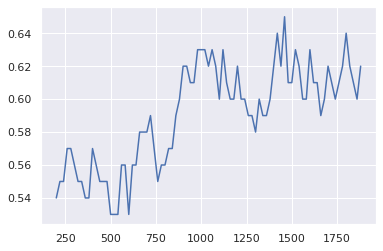

In [126]:
import seaborn as sns
sns.set_theme()
xd = 200 + np.multiply(20 , np.array(list(range(len(accs)))))
sns.lineplot(xd , y=accs)

In [127]:
np.max(np.array(accs))

0.65

In [128]:
with open(config['current_working_dir'] + "active_models_final.pckl", "wb") as f:
    pickle.dump(clfs[np.argmax(np.array(accs))], f)

In [129]:
with open(config['current_working_dir'] + "active_models.pckl", "wb") as f:
    pickle.dump(min_max_scaler, f)
    pickle.dump(variance_threshold, f)
    for model in clfs:
         pickle.dump(model, f)